### Black–Litterman model for Asset Allocation

In [1]:
# necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypfopt as pyp
import seaborn as sns
import datetime
import yfinance as yf
idx = pd.IndexSlice

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# read market capitalization and ticker details
mcap = pd.read_csv('data/mcap.csv')
mcap.head(2)

,Company Name (M.Cap),Tickers,Market Cap (Cr),Market Cap
0,Reliance Industries Ltd.(L),RELIANCE.NS,1039662,1.039660e+13
1,Tata Consultancy Services Ltd.(L),TCS.NS,775918,7.759180e+12


In [3]:
# create the tickers list
tickers = [ticker[:-3] for ticker in mcap.Tickers]
print(tickers)

['RELIANCE', 'TCS', 'HDFCBANK', 'HINDUNILVR', 'HDFC', 'BHARTIARTL', 'INFY', 'KOTAKBANK', 'ITC', 'ICICIBANK', 'MARUTI', 'NESTLEIND', 'SBIN', 'HCLTECH', 'ASIANPAINT', 'BAJFINANCE', 'LT', 'WIPRO', 'AXISBANK', 'SUNPHARMA']


In [4]:
# # data store path
# DATA_STORE = '../../../../machine-learning-for-trading-master/\
# machine-learning-for-trading-master/data/nse_asset.h5'

In [5]:
# with pd.HDFStore(DATA_STORE) as store:
#     print(store.info())

In [6]:
# # get the prices for top 20 companies
# with pd.HDFStore(DATA_STORE) as store:
#     prices = (store['/nse/nse500/prices'].loc[tickers])
# prices.head(2)

In [7]:
# # remove tickers where we have less than 10 years of data.
# min_obs = 2520
# nobs = prices.groupby(level='ticker').size()
# keep = nobs[nobs>min_obs].index

# prices = prices.loc[idx[keep,:], :]
# prices.info()

In [8]:
# fromdate=datetime.datetime(2010, 1, 1)
# todate=datetime.datetime(2020, 5, 29)

In [9]:
# # unstack and take close price
# prices = prices.unstack('ticker')['close'].sort_index()
# # prices = prices.asfreq('D', method='ffill').dropna()
# prices = prices.loc[fromdate:todate]
# prices.head(2)

In [10]:
# # save the data as .csv file
# prices.to_csv('data/prices.csv')

In [11]:
# Read daily prices from csv
prices = pd.read_csv('data/prices.csv', index_col=[0], parse_dates=[0])
prices.head(2)

,ASIANPAINT,AXISBANK,BAJFINANCE,BHARTIARTL,HCLTECH,HDFC,HDFCBANK,HINDUNILVR,ICICIBANK,INFY,ITC,KOTAKBANK,LT,MARUTI,NESTLEIND,RELIANCE,SBIN,SUNPHARMA,TCS,WIPRO
date,,,,,,,,,,,,,,,,,,,,
2010-01-04,112.664963,140.712021,16.031584,281.737823,60.860142,534.87,134.245209,221.397125,85.319977,131.975082,65.326035,202.426041,607.630798,1429.047485,475.931152,459.023529,95.066895,130.672775,279.793610,108.133598
2010-01-05,113.020851,143.647934,15.924150,286.198975,62.229534,536.69,134.363205,220.686188,86.130264,132.417114,65.969872,204.430389,608.709229,1396.256226,475.931152,456.974915,95.102180,134.599854,279.868164,109.840408


In [12]:
# create market cap dict
mcap_dict = {ticker[:-3] : cap for ticker, cap in zip(mcap['Tickers'].values, mcap['Market Cap'].values)}
print(mcap_dict)

{'RELIANCE': 10396600000000.0, 'TCS': 7759180000000.0, 'HDFCBANK': 5314330000000.0, 'HINDUNILVR': 4949320000000.0, 'HDFC': 3095350000000.0, 'BHARTIARTL': 3009290000000.0, 'INFY': 2996710000000.0, 'KOTAKBANK': 2569770000000.0, 'ITC': 2392070000000.0, 'ICICIBANK': 2209110000000.0, 'MARUTI': 1639460000000.0, 'NESTLEIND': 1600740000000.0, 'SBIN': 1581440000000.0, 'HCLTECH': 1568630000000.0, 'ASIANPAINT': 1543880000000.0, 'BAJFINANCE': 1406240000000.0, 'LT': 1305850000000.0, 'WIPRO': 1215820000000.0, 'AXISBANK': 1166750000000.0, 'SUNPHARMA': 1136330000000.0}


### Construct the prior - Implied market returns

In [13]:
# get market daily prices - BSE-500
market_prices = yf.download("BSE-500.BO", period="max")["Adj Close"]
market_prices.head(2)

[*********************100%***********************]  1 of 1 completed


Date
2007-09-17    6125.069824
2007-09-18    6192.879883
Name: Adj Close, dtype: float64

In [14]:
# calculate asset covariance and delta
# market-implied risk premium, which is the market’s excess return divided by its variance
S = pyp.risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = pyp.black_litterman.market_implied_risk_aversion(market_prices, risk_free_rate=0.05796)
print(delta)

1.1283208241080318


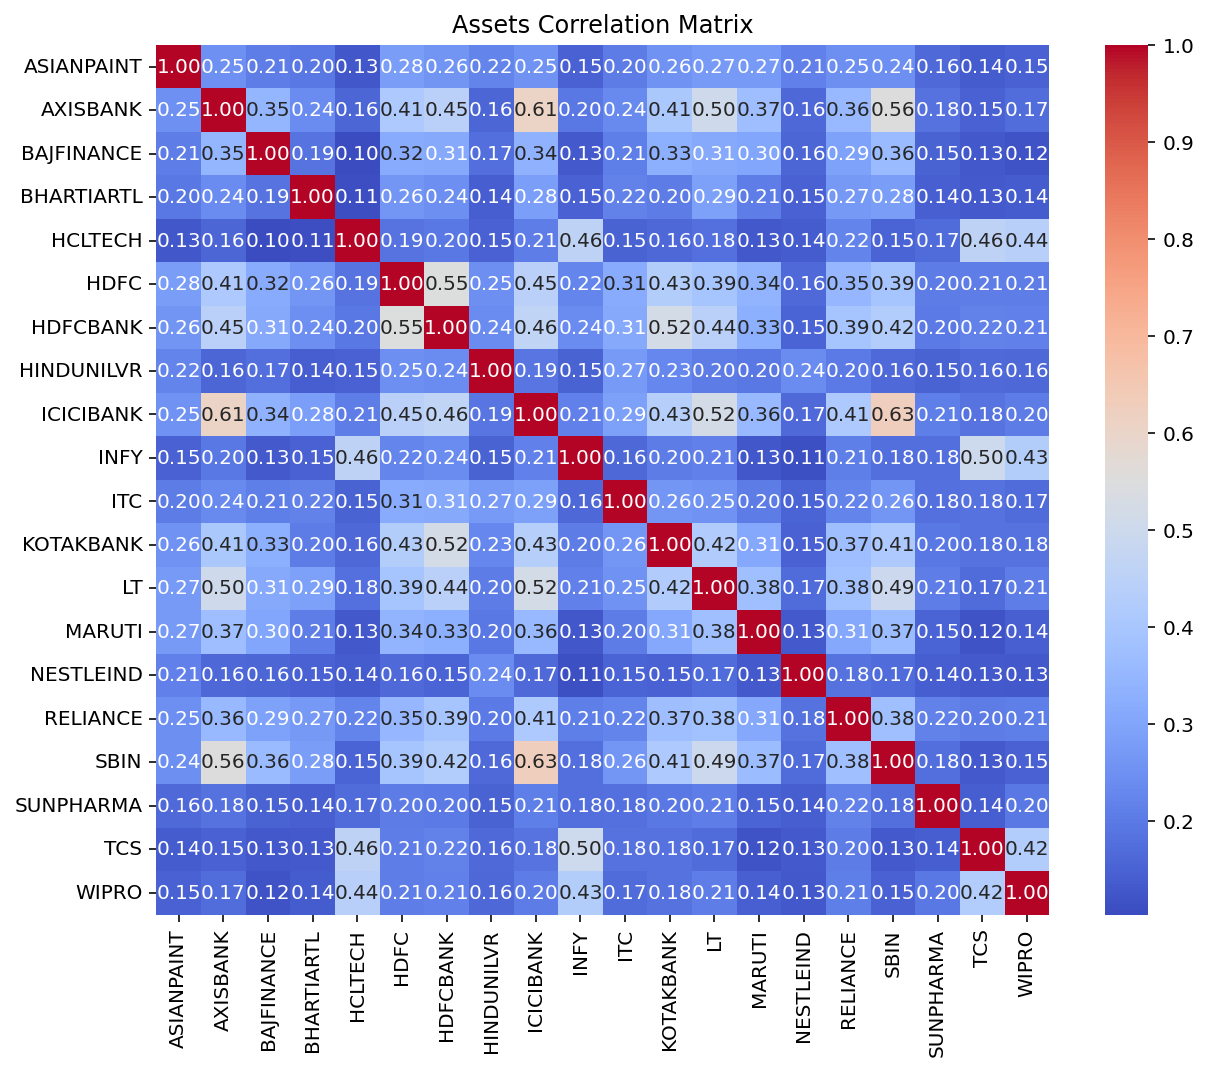

In [15]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(prices.pct_change().corr(method ='spearman'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f")
ax.set_title('Assets Correlation Matrix')
plt.savefig('images/chart1', dpi=300) 

In [16]:
# calculate prior - market implied retunrs
market_prior = pyp.black_litterman.market_implied_prior_returns(mcap_dict, delta, S)
market_prior.name = 'Prior'
print(market_prior)

ASIANPAINT    0.026242
AXISBANK      0.027249
BAJFINANCE    0.027081
BHARTIARTL    0.030527
HCLTECH       0.026604
HDFC          0.031469
HDFCBANK      0.036767
HINDUNILVR    0.034909
ICICIBANK     0.029995
INFY          0.030294
ITC           0.028302
KOTAKBANK     0.029998
LT            0.026765
MARUTI        0.027159
NESTLEIND     0.029143
RELIANCE      0.050673
SBIN          0.027849
SUNPHARMA     0.024906
TCS           0.042629
WIPRO         0.025270
Name: Prior, dtype: float64


In [18]:
sum(list(market_prior))

0.6138284459281175

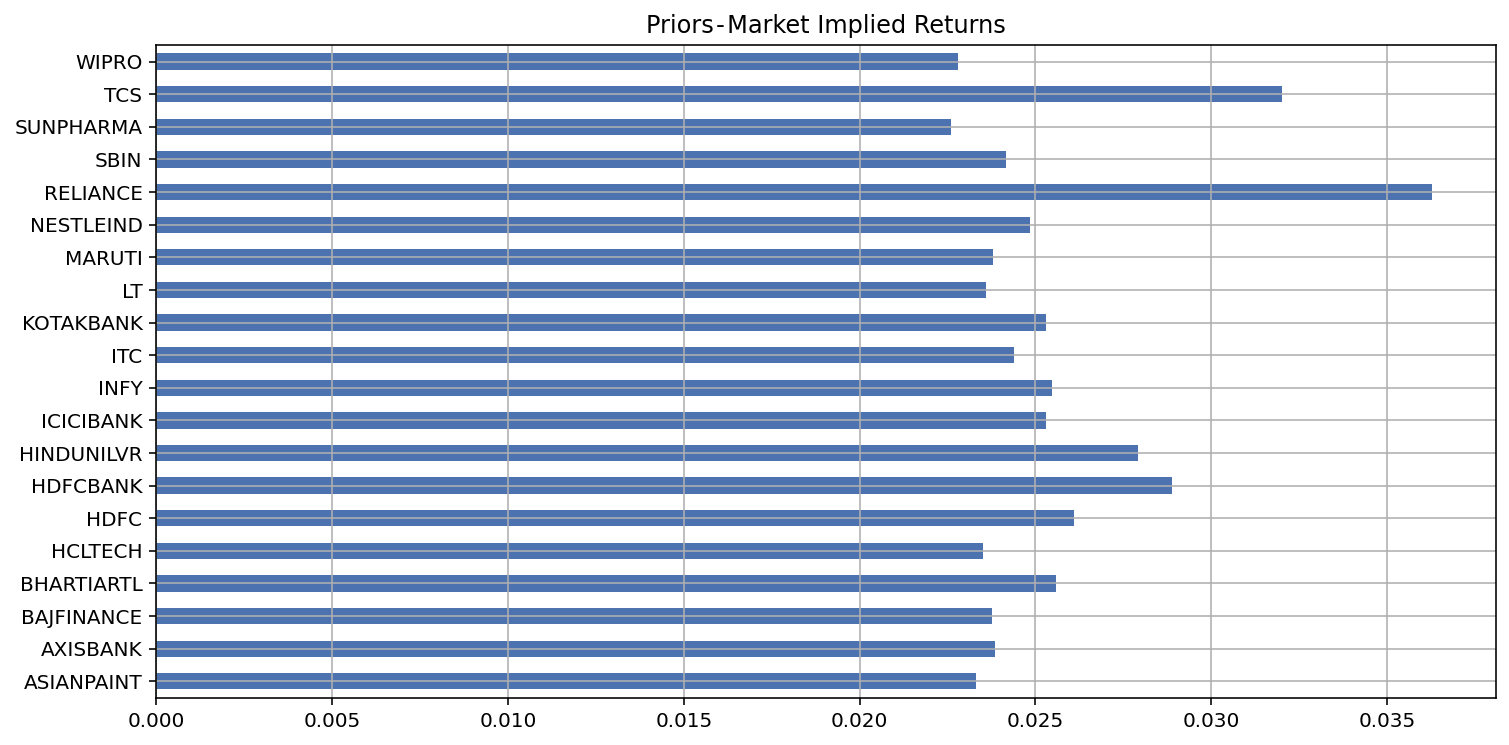

In [17]:
# plot prior
market_prior.plot.barh(figsize=(12,6), title = 'Priors - Market Implied Returns',grid=True);
plt.savefig('images/chart2', dpi=300)

In [21]:
# provide absolute views - read csv
view_confidence = pd.read_csv('data/views.csv', index_col=[0])
view_confidence.head(20)

,View,Confidences
ASIANPAINT,0.134039,0.7
AXISBANK,0.080620,0.5
BAJFINANCE,0.232234,0.5
BHARTIARTL,0.063297,0.7
HCLTECH,0.117789,0.7
HDFC,0.074361,0.7
HDFCBANK,0.105197,0.7
HINDUNILVR,0.116377,0.7
ICICIBANK,0.092490,0.7
INFY,0.096939,0.7


In [24]:
sum(list(view_confidence["View"]))

2.0593344859999996

In [19]:
# create view dict
views_dict = {ind : view_confidence['View'][ind] for ind in view_confidence.index}
print(views_dict)

{'ASIANPAINT': 0.134039338, 'AXISBANK': 0.080620015, 'BAJFINANCE': 0.23223383, 'BHARTIARTL': 0.06329739200000001, 'HCLTECH': 0.11778855, 'HDFC': 0.074360553, 'HDFCBANK': 0.105196844, 'HINDUNILVR': 0.116377075, 'ICICIBANK': 0.09249049599999999, 'INFY': 0.096939482, 'ITC': 0.071356641, 'KOTAKBANK': 0.102309112, 'LT': 0.048612752, 'MARUTI': 0.08565260300000001, 'NESTLEIND': 0.248298678, 'RELIANCE': 0.083181537, 'SBIN': 0.06122452900000001, 'SUNPHARMA': 0.08268945700000001, 'TCS': 0.109229433, 'WIPRO': 0.053436169000000006}


### Run the BL Model

In [20]:
# run the Bl model
bl = pyp.BlackLittermanModel(S, pi=market_prior, absolute_views=views_dict)

In [21]:
# Posterior estimate of returns
bl_return = bl.bl_returns()
bl_return.name = 'Posterior'

In [22]:
# get historical returns
mu = pyp.expected_returns.mean_historical_return(prices)
mu.name = 'Historical'
# print(mu)

In [23]:
# create returns dataframe
returns_df = pd.DataFrame([market_prior, mu, bl_return, pd.Series(views_dict)], 
             index=['Prior', 'Historical','Posterior', 'Views']).T
print(returns_df)

               Prior  Historical  Posterior     Views
ASIANPAINT  0.023312    0.298132   0.082649  0.134039
AXISBANK    0.023846    0.164946   0.059850  0.080620
BAJFINANCE  0.023757    0.541126   0.133050  0.232234
BHARTIARTL  0.025585    0.119428   0.048544  0.063297
HCLTECH     0.023504    0.257549   0.074213  0.117789
HDFC        0.026086    0.151362   0.056232  0.074361
HDFCBANK    0.028897    0.218670   0.072100  0.105197
HINDUNILVR  0.027911    0.247761   0.075525  0.116377
ICICIBANK   0.025303    0.192319   0.065994  0.092490
INFY        0.025462    0.203043   0.064846  0.096939
ITC         0.024405    0.141072   0.051446  0.071357
KOTAKBANK   0.025305    0.216633   0.069389  0.102309
LT          0.023590    0.085871   0.042352  0.048613
MARUTI      0.023798    0.177432   0.059959  0.085653
NESTLEIND   0.024851    0.579474   0.139187  0.248299
RELIANCE    0.036275    0.153592   0.065182  0.083182
SBIN        0.024165    0.116359   0.049317  0.061225
SUNPHARMA   0.022603    0.17

In [24]:
# write it for future reference
returns_df.to_csv('data/returns.csv', header=True,)
returns_df = pd.read_csv('data/returns.csv', index_col=[0], )

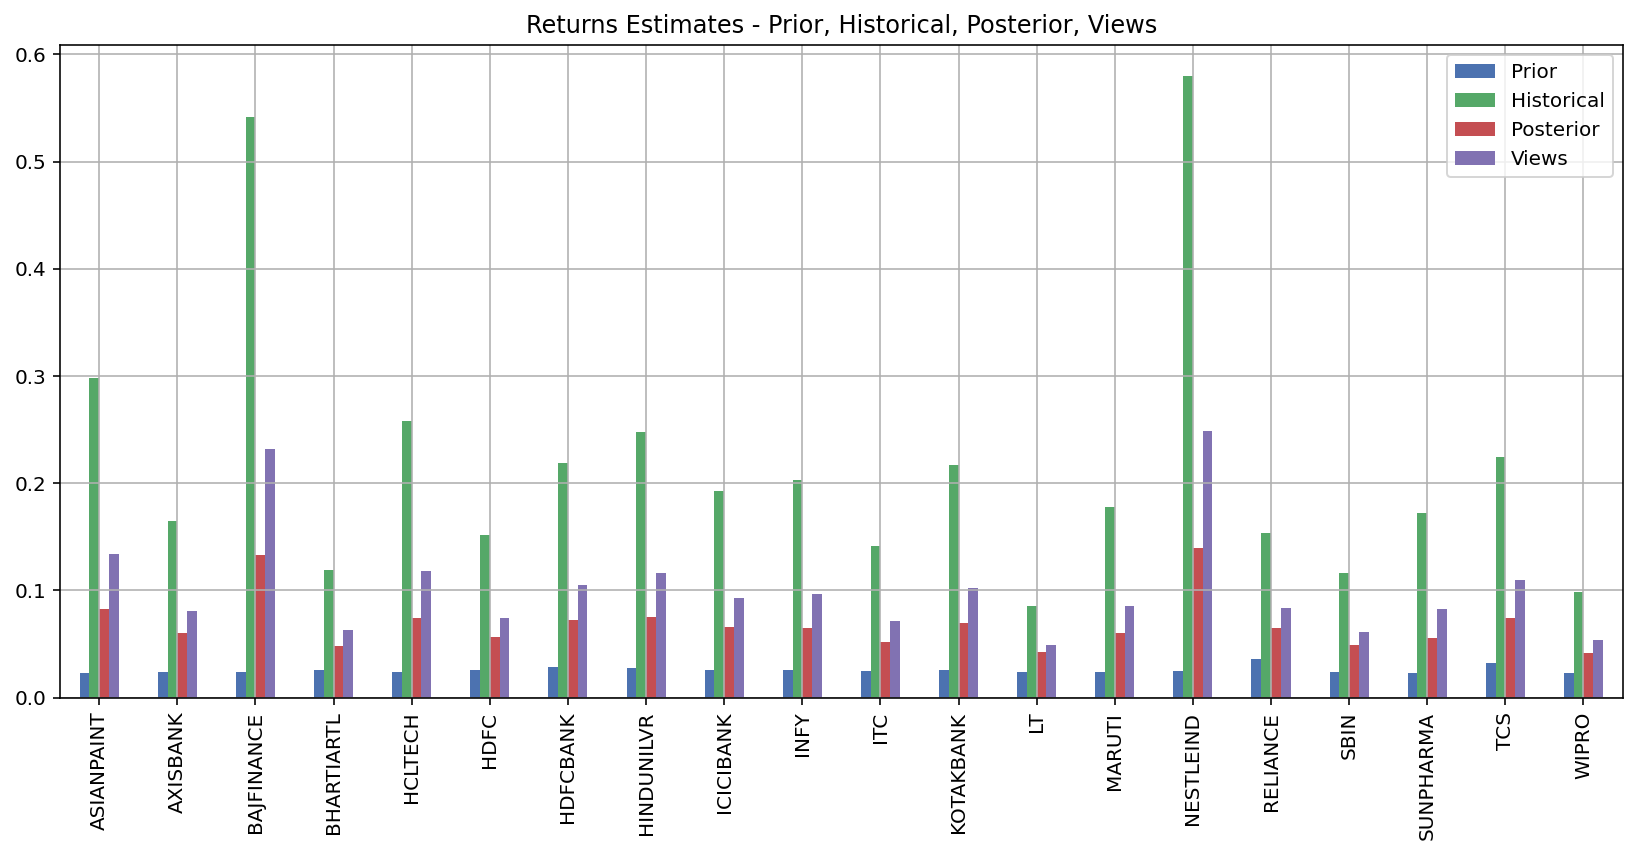

In [25]:
# plot the returns
returns_df.plot.bar(figsize=(14,6), title = 'Returns Estimates - Prior, Historical, Posterior, Views', grid=True);
plt.savefig('images/chart3', dpi=300)

In [26]:
# get the covariance matrix
S_bl = bl.bl_cov()
S_bl.to_csv('data/S_bl.csv')
S_bl = pd.read_csv('data/S_bl.csv',  index_col=[0])

### Confidence matrix for analyst views

In [27]:
# create confidences vector
confidences = list(view_confidence.Confidences)
print(confidences)

[0.7, 0.5, 0.5, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.8, 0.6, 0.7, 0.8, 0.5, 0.8, 0.7, 0.6]


In [28]:
# use Idzorek's method and run the model
bl_confi = pyp.BlackLittermanModel(S, pi=market_prior, 
                                   absolute_views=views_dict, 
                                   omega="idzorek", view_confidences=confidences)

In [29]:
# Posterior estimate of returns
bl_return_confi = bl_confi.bl_returns()
bl_return_confi.name = 'Posterior_confidence'

In [30]:
returns_df = pd.DataFrame([market_prior, mu, bl_return, pd.Series(views_dict), bl_return_confi], 
             index=['Prior', 'Historical','Posterior', 'Views', 'Posterior_confidence']).T
print(returns_df)

               Prior  Historical  Posterior     Views  Posterior_confidence
ASIANPAINT  0.023312    0.298132   0.082649  0.134039              0.103771
AXISBANK    0.023846    0.164946   0.059850  0.080620              0.061699
BAJFINANCE  0.023757    0.541126   0.133050  0.232234              0.134547
BHARTIARTL  0.025585    0.119428   0.048544  0.063297              0.055029
HCLTECH     0.023504    0.257549   0.074213  0.117789              0.092212
HDFC        0.026086    0.151362   0.056232  0.074361              0.064294
HDFCBANK    0.028897    0.218670   0.072100  0.105197              0.086026
HINDUNILVR  0.027911    0.247761   0.075525  0.116377              0.092387
ICICIBANK   0.025303    0.192319   0.065994  0.092490              0.077482
INFY        0.025462    0.203043   0.064846  0.096939              0.078256
ITC         0.024405    0.141072   0.051446  0.071357              0.059939
KOTAKBANK   0.025305    0.216633   0.069389  0.102309              0.083293
LT          

In [31]:
# write it for future reference
returns_df.to_csv('data/returns.csv', header=True,)
returns_df = pd.read_csv('data/returns.csv', index_col=[0],)

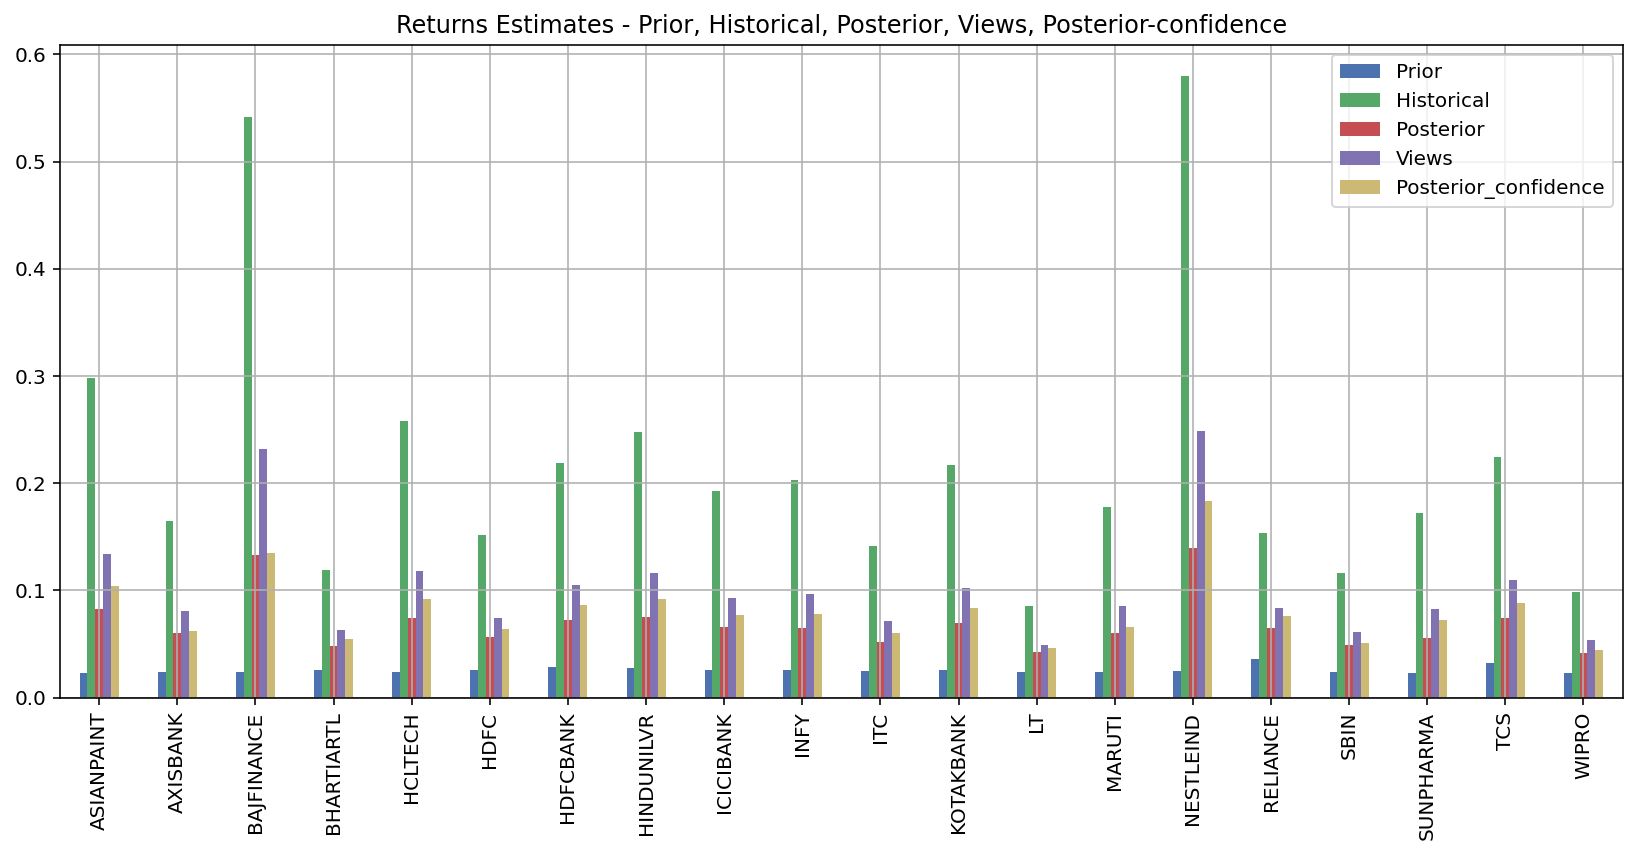

In [32]:
returns_df.plot.bar(figsize=(14,6), 
                    title = 'Returns Estimates - Prior, Historical, Posterior, Views, Posterior-confidence', grid=True);
plt.savefig('images/chart4', dpi=300)

In [33]:
# get the covariance matrix
S_bl_confi = bl_confi.bl_cov()
S_bl_confi.to_csv('data/S_bl_confi.csv')
S_bl_confi = pd.read_csv('data/S_bl_confi.csv',  index_col=[0])
S_bl_confi

,ASIANPAINT,AXISBANK,BAJFINANCE,BHARTIARTL,HCLTECH,HDFC,HDFCBANK,HINDUNILVR,ICICIBANK,INFY,ITC,KOTAKBANK,LT,MARUTI,NESTLEIND,RELIANCE,SBIN,SUNPHARMA,TCS,WIPRO
ASIANPAINT,0.142942,0.002915,0.002492,0.001822,0.001112,0.002464,0.001977,0.001754,0.002784,0.001063,0.001472,0.002320,0.002477,0.002647,0.002209,0.002215,0.002309,0.001370,0.001049,0.001104
AXISBANK,0.002915,0.150794,0.005255,0.002948,0.002222,0.004889,0.004509,0.001867,0.008258,0.002242,0.002260,0.004881,0.005927,0.004729,0.001993,0.004144,0.007249,0.002220,0.001821,0.001915
BAJFINANCE,0.002492,0.005255,0.151941,0.002517,0.001502,0.004171,0.003256,0.001941,0.004746,0.001688,0.002117,0.003977,0.003860,0.003960,0.002308,0.003202,0.004618,0.001874,0.001500,0.001417
BHARTIARTL,0.001822,0.002948,0.002517,0.146907,0.001212,0.002658,0.002177,0.001334,0.003311,0.001512,0.001775,0.002252,0.002864,0.002268,0.000776,0.002656,0.003302,0.001509,0.001200,0.001183
HCLTECH,0.001112,0.002222,0.001502,0.001212,0.144607,0.001978,0.001640,0.001362,0.002304,0.003683,0.001308,0.001741,0.001734,0.001588,0.000427,0.002209,0.001675,0.001388,0.003771,0.003350
HDFC,0.002464,0.004889,0.004171,0.002658,0.001978,0.144282,0.004127,0.001779,0.004907,0.001965,0.002483,0.004061,0.003777,0.003288,0.000699,0.003164,0.004213,0.001731,0.001744,0.001665
HDFCBANK,0.001977,0.004509,0.003256,0.002177,0.001640,0.004127,0.141626,0.001538,0.004356,0.001658,0.001943,0.003869,0.003523,0.002843,0.001113,0.002895,0.003544,0.001605,0.001518,0.001341
HINDUNILVR,0.001754,0.001867,0.001941,0.001334,0.001362,0.001779,0.001538,0.142228,0.001925,0.001157,0.001625,0.001854,0.001588,0.001775,0.001968,0.001768,0.001435,0.001228,0.001163,0.001190
ICICIBANK,0.002784,0.008258,0.004746,0.003311,0.002304,0.004907,0.004356,0.001925,0.148072,0.002338,0.002520,0.004666,0.005612,0.004231,0.001009,0.004250,0.007786,0.002180,0.001995,0.002001
INFY,0.001063,0.002242,0.001688,0.001512,0.003683,0.001965,0.001658,0.001157,0.002338,0.144324,0.001135,0.001790,0.001807,0.001341,0.000214,0.001878,0.001817,0.001295,0.003682,0.003197


### Portfolio weights

In [34]:
# Long-only minimum volatility portfolio, with a weight cap of 10% and regularisation
ef = pyp.EfficientFrontier(bl_return_confi, S_bl_confi, weight_bounds=(0, 0.1), gamma=0)
ef.add_objective(pyp.objective_functions.L2_reg, gamma=0.1)
weights = ef.min_volatility()
ef.portfolio_performance(verbose=True), print('\n')
wt_min_vola = pd.DataFrame([weights],columns=weights.keys()).T * 100

# write it to csv for part 2
wt_min_vola.to_csv('data/wt_min_vola_wts.csv')
wt_min_vola = pd.read_csv('data/wt_min_vola_wts.csv',  index_col=[0])

print ('Weights in Percentage ********************')
print(wt_min_vola.round(4))

Expected annual return: 8.0%
Annual volatility: 9.8%
Sharpe Ratio: 0.61


Weights in Percentage ********************
                 0
ASIANPAINT  5.3050
AXISBANK    4.4505
BAJFINANCE  4.7449
BHARTIARTL  5.1787
HCLTECH     5.2727
HDFC        4.8979
HDFCBANK    5.0883
HINDUNILVR  5.4644
ICICIBANK   4.5170
INFY        5.2948
ITC         5.3925
KOTAKBANK   4.9434
LT          4.8635
MARUTI      5.0163
NESTLEIND   3.7521
RELIANCE    5.0111
SBIN        4.6378
SUNPHARMA   5.3972
TCS         5.3821
WIPRO       5.3897


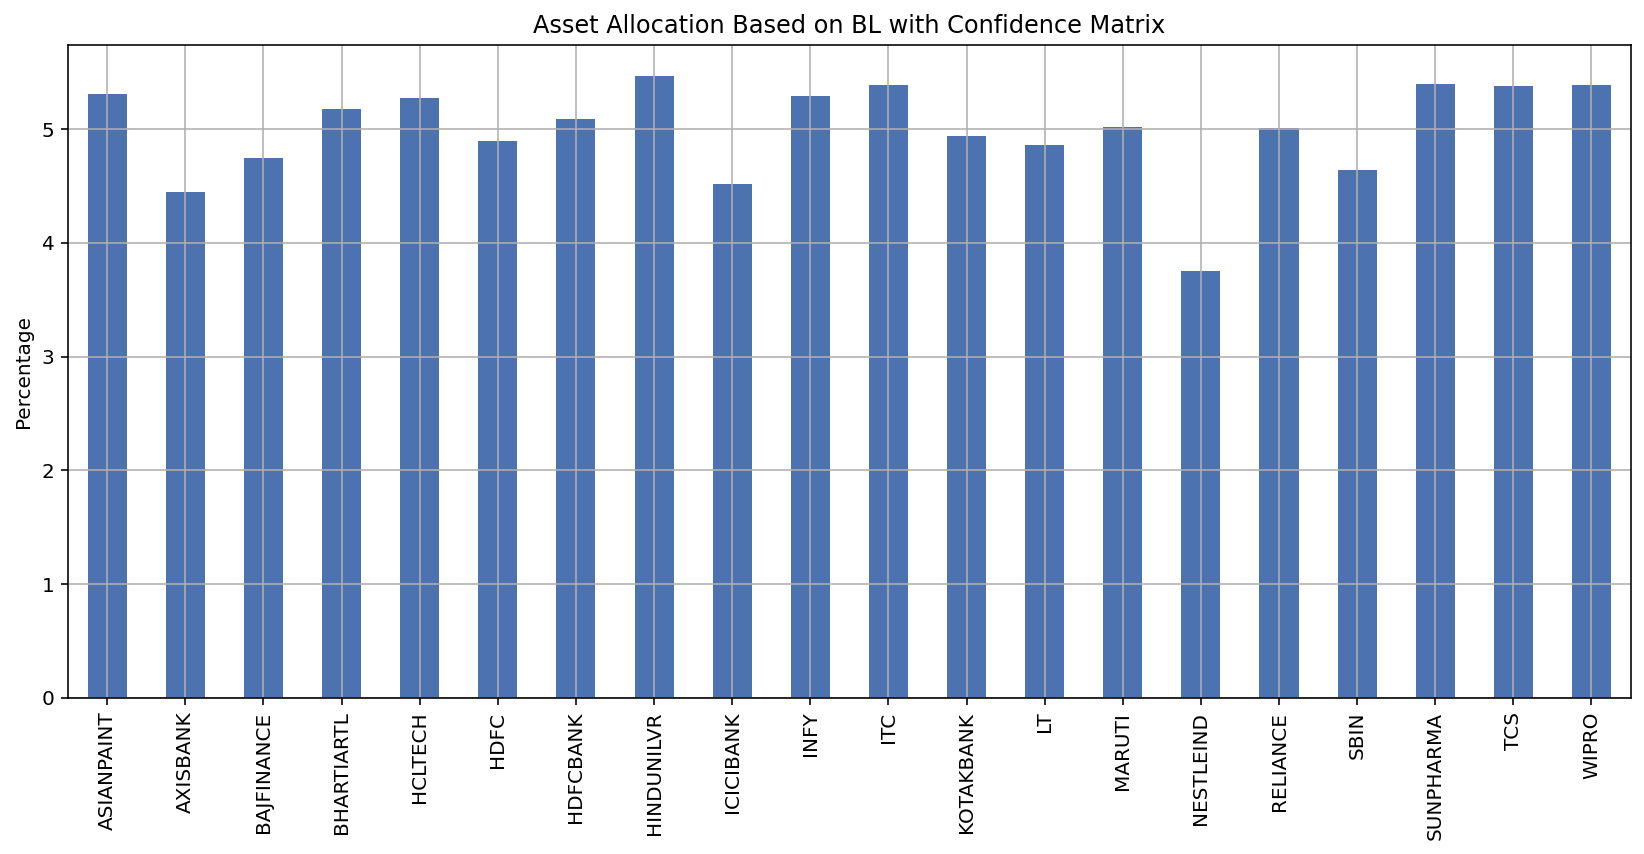

In [35]:
# plot the weights
wt_min_vola.plot.bar(figsize=(14,6), 
                    title = 'Asset Allocation Based on BL with Confidence Matrix', grid=True,legend=False);
plt.ylabel('Percentage')
plt.savefig('images/chart5', dpi=300)